# Powershell Obfuscation Analysis using Classification ML Models

This lab exercise is a continuation of the previous work we conducted in Lab 1 of our study in which our goal was to identify obfuscated data present in PowerShell script. Our ongoing objective is to identify malicious code, codifying our approach such that it can be used proactively in an enterprise setting, mitigating the risk of downtime, data leaks, and irrevocable damage to a brand's reputation.

## Data Preparation Review

To recap the work we completed in Lab 1, we started  with a corpus of 409876 PowerShell scripts collected in 2017 from GitHub, Technet, PowerShellGallery, and other sources.

Scripts from the corpus were initially unlabled and represented as, good vs bad, or obfuscated vs clean.

The scripts were individually processed to obtain the original features and analyzed for null values (there were none) leaving us originally with 10405 unique entries with 50 features. Through our initial exploratory data analysis, we whittled down our classes to a total of (2) establishing a binary classification problem, specifically represented as 'known obfuscated' versus 'NOT obfuscated.' 

Through additional transformations conducted, including converting the character features to percentage based values, adding a feature that had the total number of keywords instead of the number of each keyword, and then normalizing the values to create an even ratio we created our transformed dataset.

In [1]:
# Custom Class for standardization data flow. Source listed in Appendix 
from ps_obf import PS_OBF
# Global libraries 
import numpy as np
import seaborn as sns
from sklearn import svm
from sklearn.svm import SVC
from sklearn import metrics as mt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
# Matplotlib 
import warnings
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
plt.style.use('ggplot')
# PS_OBF Class Libraries 
import os
import pickle
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

Using the custom PS_OBF class we can pass through our csv file and let it take that data and achieve two main objectives: 1. Modify that data using dimension reduction techniques and transformations, and 2: Create a data set using PCA with 2 n-components. The transformed data will be assigned to the "df" variable and the PCA data will be assigned to the "pca_df" variable.

In [2]:
my_var= PS_OBF('../dataset/all_with_keyword_sum.csv', transform=True)

# Assign the transformed dataframe
df = my_var.data
# Assign the PCA dataframe 
pca_df = my_var.pca_df

# Create an empty list to store the models for future use. It will be a list of lists
# where given list.append([x, y, z]), x = title of model, y = model, z = confusion matrix  
list_of_models = []
def _append(lst):
    '''Small validation to avoid appending the same model multiple times if the notebook is 
    ran more than once'''
    if len(list_of_models) > 0:
        tmp_lst = []
        for mdl in list_of_models:
            tmp_lst.append(mdl[0])
        if lst[0] not in tmp_lst:
            list_of_models.append(lst)
    else:
        list_of_models.append(lst)

In [3]:
# Function to get Confusion Matrix Rates
def get_conf_matrix_rates(confusion_matrix):
    '''Create function to calculate Accuracy, Precision, Recall, and F1 scores given a Confusion Matrix.
    Returns: Dictionary of Keys: ['accuracy'], ['precision'], ['recall'], ['f1'] '''
    tp, tn = confusion_matrix[1][1], confusion_matrix[0][0]
    fn, fp = confusion_matrix[1][0], confusion_matrix[0][1]
    matrix_rates = dict()
    matrix_rates['accuracy'] = (tp+tn)/(tp+fn+tn+fp)
    matrix_rates['precision'] = tp/(tp+fp)
    matrix_rates['recall'] = tp/(tp+fn)
    matrix_rates['f1'] = 2*(
        (matrix_rates['precision']*matrix_rates['recall']) / (matrix_rates['precision']+matrix_rates['recall'])
        )

    return(matrix_rates)

In [4]:
# Show some basic information about the transformed data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10405 entries, 384192 to 408879
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   is_obf              10405 non-null  int8   
 1   char_hash_count     10405 non-null  int64  
 2   char_paren_count    10405 non-null  int64  
 3   char_brack_count    10405 non-null  int64  
 4   char_brace_count    10405 non-null  int64  
 5   char_bkslash_count  10405 non-null  int64  
 6   char_fwslash_count  10405 non-null  int64  
 7   char_dollar_count   10405 non-null  int64  
 8   char_squote_count   10405 non-null  int64  
 9   char_dquote_count   10405 non-null  int64  
 10  char_bktick_count   10405 non-null  int64  
 11  char_colon_count    10405 non-null  int64  
 12  char_scolon_count   10405 non-null  int64  
 13  char_star_count     10405 non-null  int64  
 14  char_minus_count    10405 non-null  int64  
 15  char_plus_count     10405 non-null  int64  
 16

The transformed data set has a total of 10405 observations with 30 features and one column (is_obf) as our target column.

In [5]:
# At this stage the PCA data is still a numpy array
print("pca_df Details:\n-------------\n" + str(pca_df.shape))

pca_df Details:
-------------
(10405, 2)


The principal component analysis which includes a dataset of 10405 observations and 2 principal components we will compare in our modeling going forward.

In [6]:
# Define common random seed value and sample test percentage size.
# Uses the seed from the PS_OBF object
seed_value = my_var.rd_seed

## Split data into 80/20 Train Test

In [7]:
# Split data using the built in method from our custom class
# Returns python dictionary with these keys
# train, test, train_features, test_features, train_labels, test_labels
pca_split = my_var.split(my_var.pca_df)
data_split = my_var.split(my_var.data)

## Logistic Regression Model

Given we're dealing with a classification problem, we'll start by leveraging logistic regression for our analysis.

In [8]:
# Function to generate logistic regression model
def create_logistic_model(data, label, seed=None):
    '''Function to create a logistic regression model. When ran it will display the accuracy and confusion matrix of the model.
    @Params:
    - dataframe (pandasDataframe) : Dataframe Object
    - label (str) : name of the column that defines the label 
    - seed (optional) (int) : integer value for a seed
    @Returns: fitted LogisticRegression()
    '''
    # Create logistic regression model
    logreg_model = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear', max_iter=150) 
    
    # Data split
    df_train, df_test = data['train'], data['test']
    df_train_features, df_test_features = data['train_features'], data['test_features']
    df_train_labels, df_test_labels = data['train_labels'], data['test_labels']

    # Fit the model
    logreg_model.fit(df_train_features, df_train_labels)

    # Test out the model and create predictions 
    logreg_pred = logreg_model.predict(df_test_features)
    # get accuracy 
    logreg_accuracy = mt.accuracy_score(df_test_labels, logreg_pred)
    # Confusion Matrix 
    logreg_conf = mt.confusion_matrix(df_test_labels, logreg_pred)
    # Display results 
    print("Accuracy: ", logreg_accuracy)
    print('Confusion Matrix: \n', logreg_conf)

    return(logreg_model, logreg_conf)

Pertaining to hyperparameters or 'tuning' we executed, we incorporated the 'liblinear' solver and a penalty of '12'. Parameters can be especially useful in stochastic gradient descent exercises, and in this example, where our aim is to best classify and fit our model based on the features provided. SGD is highly efficient and easy to implement but potentially comes at the cost of feature scaling and number of iterations required to reach an optimal result.

The penalty parameter is used to penalize a model when there is presence of too many variables as to reduce the weight of the coefficients that have less importance to our model- this is also known as 'regularization'. The 'liblinear' solver uses a Coordinate Descent algorithm to solve for large-scale regularized classification and regression problems- and of course, this is intended to work in parallel to the penalty parameter.

Iterations were increased from the default 100 to 150 because of the size of the dataset. Any lower and the model would throw warnings. 

In [9]:
print('Transformed Data Model and Results')
tf_data_logreg_model, tf_logreg_conf_mtrx = create_logistic_model(data_split, 'is_obf', seed_value)
_append(['Transformed Data - Logistic Model', tf_data_logreg_model, tf_logreg_conf_mtrx])

Transformed Data Model and Results
Accuracy:  0.9466602594906295
Confusion Matrix: 
 [[ 630   10]
 [ 101 1340]]


In [10]:
print('PCA Model and Results')
pca_logreg_model, pca_logreg_conf_mtrx = create_logistic_model(pca_split, 'is_obf', seed_value)
_append(['PCA Data - Logistic Model', pca_logreg_model, pca_logreg_conf_mtrx])

PCA Model and Results
Accuracy:  0.9452186448822681
Confusion Matrix: 
 [[ 639    1]
 [ 113 1328]]


Above are the results of running logistic regression models on our two different data sets. The data sets loaded included the transformed data set, which includes 10405 observations and 49 features, and finally, the PCA data set, which includes 10406 observations, 2 Principal Components and a column represented as 'is_obf' levels.

We ran logistic regression, given this study is based on a binary response, meaning, based on the observations within the inputted features of each data set, can we classify a record (a PowerShell script) to either be known obfuscated or NOT obfuscated?

The confusion matrices, also known as error matrices, which assess the performance of classifying the variables under logistic regression have roughly similar results. 

In the transformed data model, there were 612 true positives, 28 false positives, 55 false negatives, and 1386 true negatives with a 96% accuracy. For the PCA model, we observe 639 true positives, 1 false positive, 113 false negative, and 1328 false negative with a 94.5% accuracy.

We especially want to be concerned with the false negatives present- in a real world scenario those results potentially put an enterprise at risk of obfuscated code appearing innocuous, making its way into production environments, thereby leading to a variety of potential cybersecurity risk.

In [11]:
def get_logreg_weights(dataframe, log_model, label_name, title=None, v=False):
    '''Prints the weights of each feature in the model and displays a graphic. Returns nothing. 
    @Params:
    - dataframe (PandasDataframe) : Dataframe used when creating the model
    - log_model (LogisticRegression) : Model returned from the create_logistic_model() function
    - label_name (string) : name of the lable column used to created the model
    - title (string) : Title of the bar graph
    - v (bool) : If true, prints the weights. If False, only prints chart
    '''
    # Create dataframe to send to bar grpah 
    logreg_tmp_df = dataframe[dataframe.columns[dataframe.columns != label_name]]
    logreg_wghts = pd.DataFrame(log_model.coef_[0], columns=['value'], index=logreg_tmp_df.columns)

    # display those that have a weight greater than .001
    logreg_wghts = logreg_wghts.loc[(logreg_wghts["value"] >= .001) | (logreg_wghts["value"] <= -.001)]

    # Plot / Display
    if title == None: 
        logreg_wghts.plot(kind='bar', title='Feature Weights')
    else:
        logreg_wghts.plot(kind='bar', title=title)
        
    plt.show()

    if v == True:
        # Display text Versions 
        # Get the weights for each variable 
        logreg_vars = zip(log_model.coef_.T, logreg_tmp_df)
        logreg_vars = sorted(logreg_vars)
        # Display Weights 
        print('\nFeature Weights\n---------------------')
        for coef, name in logreg_vars:
            print(name, 'weight: ', coef[0])

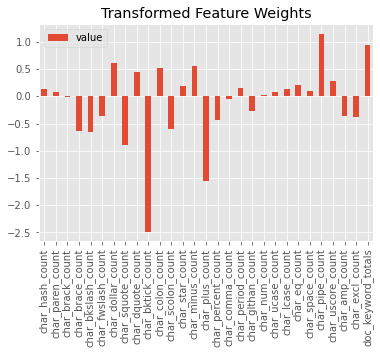

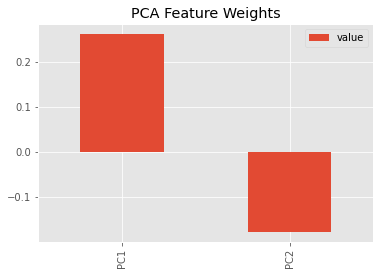

In [12]:
# Display Weights for Transformed Data
get_logreg_weights(df, tf_data_logreg_model, 'is_obf', title='Transformed Feature Weights', v=False)
# Display Weights for PCA Data
get_logreg_weights(my_var.pca_with_label_df, pca_logreg_model, 'is_obf', title='PCA Feature Weights', v=False)

Displayed above are the weights asssociated with the logistic regression models we derived from our (2) data sets. It's important to first delineate how logistic regression lends to classification over linear regression, for example. Linear regression fits a straight line or hyperplane, whereas logistic regression models use logistic functions to fit according to the output of a linear equation between a binary, '0' and '1'. A weight can be interpreted as a change in a value by one unit to increase the log odds ratio by the value of a corresponding weight.

In the Transformed Feature Weights plot, 'char_bktick_count' has the most statistical significance in addition to the aggregate column we added, 'doc_keyword_sum'. This finding corroborates what we observed in our exploratory data analysis. Finally, looking at the PCA Feature Weights plot we can see PC1 has the most significance- recall from our EDA this signifies the features, 'doc_avg_line_len' and doc_line_count', have the most weight pertaining to our study and classification of known obfuscated versus NOT obfuscated.

In summary, the 'doc_keyword_sum' feature from the transformed feature weights plot and 'doc_avg_line_len' and doc_line_count' from the PCA Data set align with our exploratory analysis, whereas 'char_bktick_count' from the transformed feature weights plot presents an interesting and new result worth investigating further.

## Naive Bayes Classification


In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

def create_nb_model(data, label, do_pca=False):
    clf_mnb = MultinomialNB(alpha=1.0)
    clf_bnb = BernoulliNB(alpha=1.0, binarize=0.0)

    # Data split
    y_train, y_test = data['train'], data['test']
    X_train, X_test = data['train_features'], data['test_features']
    df_train_labels, df_test_labels = data['train_labels'], data['test_labels']
    if do_pca:
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
 
    # Create a list of alpha values from 0 to 1
    alpha_list = np.arange(0, 1, .1).tolist()
    bin_list = np.arange(0, 1, .1).tolist()

    #multinominal top acc and alpha
    mnb_top_acc = 0
    mnb_top_acc_alpha = None

    #bernoulli top acc alpha and bin
    bnb_top_acc = 0
    bnb_top_acc_alpha = None
    bnb_top_acc_bin = None

    # gaussian accuracy
    gnb_top_acc = 0

    gnb_top_model = None
    mnb_top_model = None
    bnb_top_model = None
    top_model = None
    top_acc = None

    # gaussian
    clf_gnb_new = GaussianNB()
    clf_gnb_new.fit(X_train, y_train.is_obf)
    clf_gnb_new_y_hat = clf_gnb_new.predict(X_test)
    gnb_top_acc = accuracy_score(clf_gnb_new_y_hat, y_test.is_obf)
    gnb_top_model = clf_gnb_new

    # multinominal and Bernoulli with hyperparameter tuning of alpha and bin
    for a in range(len(alpha_list)):
        # MNB
        clf_mnb_new = MultinomialNB(alpha=alpha_list[a])
        clf_mnb_new.fit(X_train, y_train.is_obf)
        clf_mnb_new_y_hat = clf_mnb_new.predict(X_test)
        clf_mnb_new_acc = accuracy_score(clf_mnb_new_y_hat, y_test.is_obf)
        
        if clf_mnb_new_acc > mnb_top_acc:
            mnb_top_acc = clf_mnb_new_acc
            mnb_top_acc_alpha = alpha_list[a]
            # get top multinominal nb model by accuracy
            mnb_top_model = clf_mnb_new

        # BNB
        for b in range(len(bin_list)):
            clf_bnb_new = BernoulliNB(alpha=alpha_list[a], binarize=bin_list[b])
            clf_bnb_new.fit(X_train, y_train.is_obf)
            clf_bnb_new_y_hat = clf_bnb_new.predict(X_test)
            clf_bnb_new_acc = accuracy_score(clf_bnb_new_y_hat, y_test.is_obf)

            if clf_bnb_new_acc > bnb_top_acc:
                bnb_top_acc = clf_bnb_new_acc
                bnb_top_acc_alpha = alpha_list[a]
                bnb_top_acc_bin = bin_list[b]
                # get the top bernoulli nb model by accuracy
                bnb_top_model = clf_bnb_new

    # get the top model, accuracy, and confusion matrix
    top_model = mnb_top_model if mnb_top_acc > bnb_top_acc else bnb_top_model
    top_acc = mnb_top_acc if mnb_top_acc > bnb_top_acc else bnb_top_acc
    top_model = top_model if top_acc > gnb_top_acc else gnb_top_model
    top_acc = top_acc if top_acc > gnb_top_acc else gnb_top_acc

    print('Top model is:', top_model, ' with accuracy of:', top_acc)
    y_pred = top_model.predict(X_test)
    conf_mat = mt.confusion_matrix(data['test_labels'], y_pred)
    print('Confusion Matrix: \n', conf_mat)
    # return the top model 
    return top_model, conf_mat

print('Transformed Model and Results')
tf_data_nb_model, tf_nb_conf_mtrx = create_nb_model(data_split, 'is_obf')
_append(['Transformed Data - {}'.format(str(type(tf_data_nb_model))), tf_data_nb_model, tf_nb_conf_mtrx])

print('\n')

print('PCA Model and Results')
pca_nb_model, pca_nb_conf_mtrx = create_nb_model(pca_split, 'is_obf', True)
_append(['PCA Data - {}'.format(str(type(pca_nb_model))), pca_nb_model, pca_nb_conf_mtrx])

Transformed Model and Results
Top model is: MultinomialNB(alpha=0.0)  with accuracy of: 0.8750600672753484
Confusion Matrix: 
 [[ 513  127]
 [ 133 1308]]


PCA Model and Results
Top model is: GaussianNB()  with accuracy of: 0.9437770302739068
Confusion Matrix: 
 [[ 640    0]
 [ 117 1324]]


Above, we executed Naive Bayes using three variants of the model, "Bernoulli", "Multinomial", and "Gaussian." In review, Bernoulli is designed to support features when they are all binary, in this case 'is not obfuscated' versus 'obfuscated'. Multinomial NB takes discrete data and identifies how often an observation is classified as 'is not obfuscated' or 'obfuscated' helping the model derive a response and its accuracy. Finally, Gaussian is simply based on taking continuous observations and assuming a normal distribution, determining where the cut-off should be to produce the most accurate result.

We ran multiple permutations using an alpha up to '1.0' to produce the model with the most optimal result, illustrated through the accuracy. Interestingly with the Naive Bayes model we see different accuracy results. Namely, there is an increase in false negatives with the transformed model (in fact, even more than the PCA model) using Multinomial Naive Bayes versus the logistic regression model results from above based on a 95% confidence interval. The PCA model, based on Gaussian Naive Bayes, has a very similar accuracy result as the logistic regression model from earlier.

## K-NN Model

Best K Neighbors for Transformed Data K-NN is k=73
Accuracy: 0.9663623258049014
Confusion Matrix: 
 [[ 617   23]
 [  47 1394]]
Best K Neighbors for PCA Data K-NN is k=59
Accuracy: 0.9605958673714561
Confusion Matrix: 
 [[ 618   22]
 [  60 1381]]


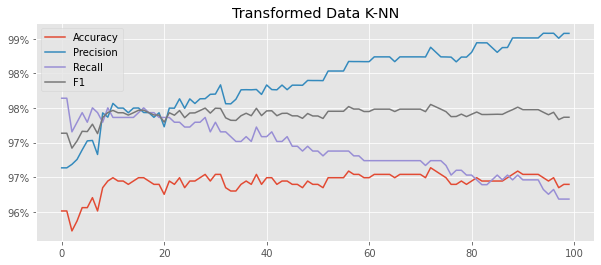

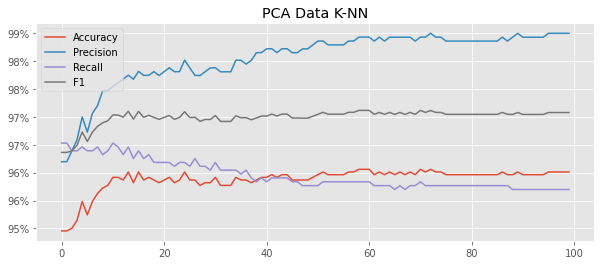

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.ticker import FuncFormatter

# Create function to find optimal K value
def get_opt_knn_model(data, title, show_chart=True):
    '''Find the optimal number of K-Neighbors. 
    Shows line chart of k-values if show_chart set to true.
    '''
    # Dataframe to hold the metrics from the model
    model_title = title
    results = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1'])
    top_model = None
    top_f_one = 0.0
    top_k_cand = ''
    top_conf_matrix = None
    top_acc = 0.0

    for k in range(1, 101):
        clf = KNeighborsClassifier(n_neighbors=k, weights='distance')
        clf.fit(data['train_features'], data['train_labels'])
        y_hat = clf.predict(data['test_features'])
        # Create the confusion matrix
        clf_conf = mt.confusion_matrix(data['test_labels'], y_hat)
        # Pass the matrix to the function to calculate metrics (or rates)
        conf_rate = get_conf_matrix_rates(clf_conf)
        results.loc[len(results.index)] = [
            accuracy_score(y_hat, data['test_labels']), conf_rate['precision'], 
                           conf_rate['recall'], conf_rate['f1']]
        # Check to see if it this configuration if the best for our use case
        if float(conf_rate['f1']) > top_f_one:
            top_model = clf
            top_f_one = conf_rate['f1']
            top_k_cand = "k={}".format(str(k))
            top_conf_matrix = clf_conf
            top_acc = conf_rate['accuracy']

    if show_chart == True:
        ax = results.plot(figsize=(10,4), title=model_title)
        # Sets the y-axis to be based on a percentage 
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

    print('Best K Neighbors for {} is {}\nAccuracy: {}'.format(model_title, top_k_cand, top_acc))
    print('Confusion Matrix: \n', top_conf_matrix)
    
    return(top_model, top_conf_matrix)

# K-nn for Transformed data 
tf_knn_model, tf_knn_matrix = get_opt_knn_model(data_split, 'Transformed Data K-NN')
_append(['Transfomed Data - KNN Model', tf_knn_model, tf_knn_matrix])

# K-nn for PCA Data
pca_knn_model, pca_knn_matrix = get_opt_knn_model(pca_split, title='PCA Data K-NN')
_append(['PCA Data - KNN Model', pca_knn_model, pca_knn_matrix])

Finally, we ran K-NN, another type of classification model used to understand unlabeled observations based on the nearest neighbors (other observations around it) given K. K-NN, actually, produces the highest accuracy with both data sets, even over logistic regression. In the transformed dataset, the optimal k value is '5' whereas in the PCA dataset we have a much larger k value of '46'. Typically, the smaller the k-value the higher the possibility for noise in the dataset influencing the classification results. Conversely, much larger k-values are computationally intensive due to the number of folds (or permutations) that need to be run.

The plots above illustrate the performance varying metrics respective to the K-NN models executed. While accuracy represents the base metric used for model evaluation, the others tell a story as well. Accuracy takes the number of correct predictions and divides the value over all predictions. Precision measures how many of the positive predictions made are actually true positives. Recall, otherwise known as sensitivity, looks at how many of the positive cases were actually classified correctly dividing the value over all positive cases in the data. ANd finally, the F1 score takes, both, precision and recall, to come up with a mean based on the two ratios.

Taking all this information, the plots corroborate the statistical output, respective to the optimal K-NN value. Specifically, we see in the transformed dataset plot, accuracy reaches its peak at 5 before tapering off with a slight increase at K-NN= 45 before decreasing again. In the PCA K-NN plot, we see a gradual increase in accuracy as more K-folds are introduced with a peak being reached at 46, before a slight drop and some hovering again at the highest accuracy with more K-folds. Again, the goal is to achieve the highest accuracy without introducing more K-NN folds than are necessary while avoiding additional cost, by way of increase computational resources and usage.

## Summary

### Confusion Matrix Comparison

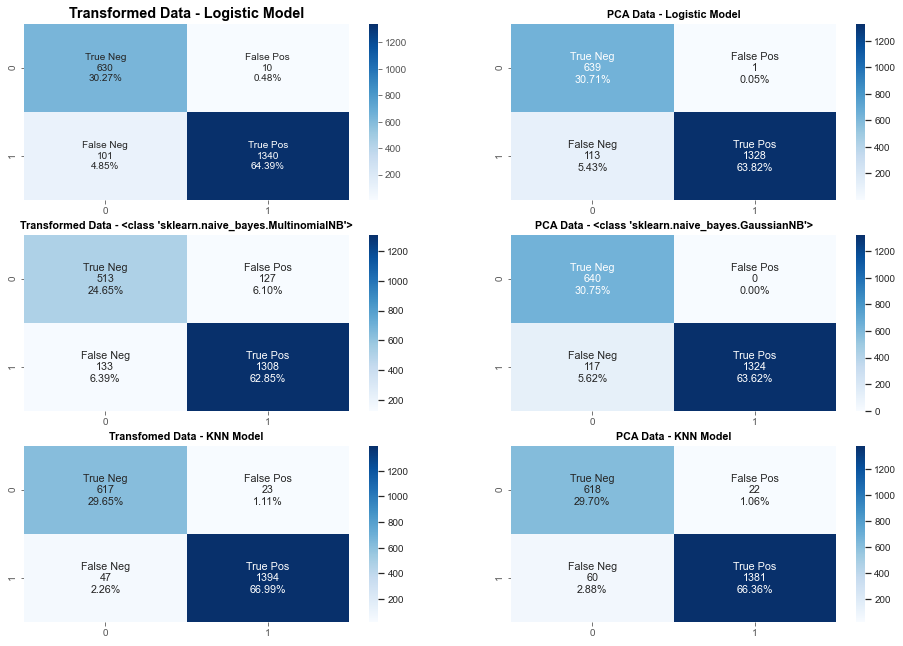

In [15]:
def show_conf_matrix(model_list, num_of_columns=2):
    '''Function for creating and plotting graphical confusion matrix'''
    fig, axs = plt.subplots(3, ncols=num_of_columns)
    fig.set_figheight(11); fig.set_figwidth(16)
    h_pos, v_pos = 0, 0 # Contains current position on plot to put chart 
    for i in range(len(model_list)):
        conf_matrix = model_list[i][2] 
        title = model_list[i][0]
        group_names = ['True Neg','False Pos','False Neg','True Pos']
        group_counts = ['{0:0.0f}'.format(value) for value in conf_matrix.flatten()]
        group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
        labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        # Display the confusion matrix
        sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues', ax=axs[v_pos, h_pos]).set_title(
            str(title), fontdict={'weight':'bold'}
            )
        sns.set(font_scale=.9)
        # Increment the position 
        if h_pos == num_of_columns-1: 
            h_pos = 0;  v_pos += 1
        else:
            h_pos += 1

show_conf_matrix(list_of_models, num_of_columns=2)

### Comparing Accuracy, Precision, Recall and F1 scores

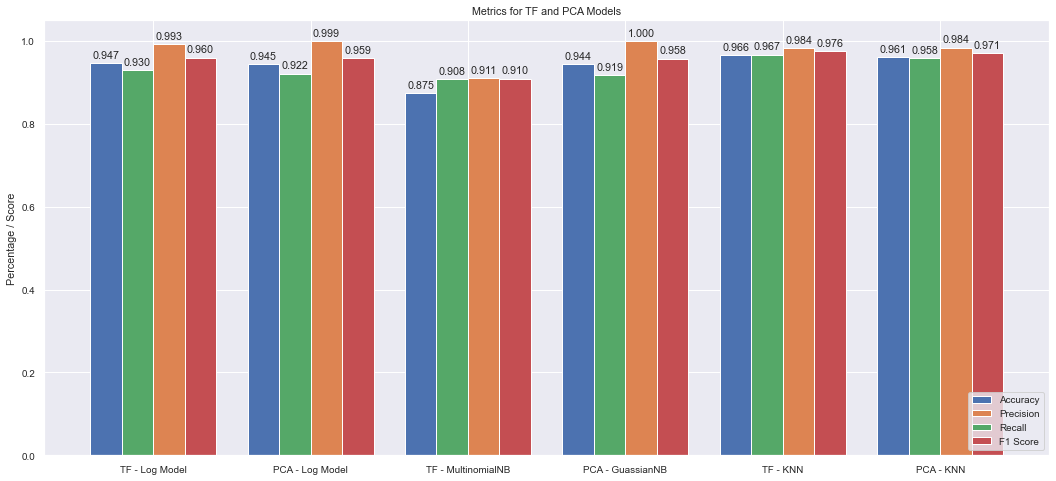

In [16]:
# Get model metric information. The order here is the order the models were added
metrics = [
    get_conf_matrix_rates(list_of_models[0][2]), # tf_log
    get_conf_matrix_rates(list_of_models[1][2]), # pca_log 
    get_conf_matrix_rates(list_of_models[2][2]), # tf_mnb
    get_conf_matrix_rates(list_of_models[3][2]), # pca_mnb 
    get_conf_matrix_rates(list_of_models[4][2]), # tf_knn 
    get_conf_matrix_rates(list_of_models[5][2])  # tf_log 
    ]

# Create data list for each category and loop through and assign values
bar_acc, bar_prec, bar_recall, bar_f_one = [],[],[],[]
for metric in range(len(metrics)):
    bar_acc.append(metrics[metric]['accuracy'])
    bar_prec.append(metrics[metric]['precision'])
    bar_recall.append(metrics[metric]['recall'])
    bar_f_one.append(metrics[metric]['f1'])

metric_labels = ['TF - Log Model', 'PCA - Log Model', 'TF - MultinomialNB', 'PCA - GuassianNB', 
                 'TF - KNN', 'PCA - KNN']
# Plot Properties     
metric_x = np.arange(len(metric_labels))
bar_width = .20
fig, ax = plt.subplots()
fig.set_figheight(8); fig.set_figwidth(18)
# Bar Positions 
rects1 = ax.bar((metric_x - bar_width/2)-(bar_width), bar_acc, bar_width, label='Accuracy')
rects2 = ax.bar(metric_x + bar_width/2, bar_prec, bar_width, label='Precision')
rects3 = ax.bar(metric_x - bar_width/2, bar_recall, bar_width, label='Recall')
rects4 = ax.bar((metric_x + bar_width/2)+(bar_width), bar_f_one, bar_width, label='F1 Score')
# Labels and stuff
ax.set_ylabel('Percentage / Score')
ax.set_title('Metrics for TF and PCA Models')
ax.set_xticks(metric_x, metric_labels)
ax.legend()
# Add labels to the bars 
ax.bar_label(rects1, padding=3, fmt='%.3f')
ax.bar_label(rects2, padding=3, fmt='%.3f')
ax.bar_label(rects3, padding=3, fmt='%.3f')
ax.bar_label(rects4, padding=3, fmt='%.3f')
plt.legend(loc='lower right')
plt.show()

In summary, the highest accuracy produced amongst all three models (and respective permutations in the example of Naive Bayes), is the K-NN model using the PCA dataset. This makes sense since PCA aims to reduce dimensionality and helps us isolate the features that have statistical significance respective to the business problem we're trying to solve for, in this scenario, classifying obfuscated versus not obfuscated data.

Taking our analysis and applying it in real world context, let's assume on average a junior forensic examiner will take approximately 1 to 2 hours to review 50 - 100mb of ONLY PowerShell event log data (event id 4104) per system. Examiners are assigned 10 - 20 systems per engagement (this will scale to the size of the engagement... more boxes = more examiners). If the client is not covered by insurance, they can expect to pay the market rate of approximately 500/hour for the work. With these numbers this translates to non-covered investigations cost 500 - 1000 per system and 5000 to 20000 per engagement. Now, if we can reduce the total time to review the PowerShell event log data by ~50% (by providing investigative leads through the detection of obfuscated PowerShell) the effective savings to the customer will range from 2500 to 10000 per investigator per engagement. Additionally, we could potentially reduce the number of "misses" in the analysis. (this happens way more then you would think... routinely engagements have 3rd party forensic teams reviewing the work of other teams).

This is powerful, representing a compelling business case which should be considered for further investments, through time and resoures, as part of our aspiration to operationalize this analysis in an enterprise setting.

## Appendix 

## Custom Class Source Code <br>
Stored in same directory as Notebook

In [17]:
import os
import pickle
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


class PS_OBF:
	'''Class to create a standardization for the way we process data and create models.
	When the object is created a transformation will automatically happen that creates a
	new dataframe based on standard options, additional transofrmation will happen if
	set to true, and PCA models and dataframes will be created.

	@Params:
		csv_path (str) : Locations of the csv file
		transform (bool) : True to apply ratio transformation. False to apply standard transform
	'''
	def __init__(self, csv_path, transform=False):
		self.csv_path = csv_path
		self.transform = transform
		self.original_data = None
		self.data = None # working data that is modified
		self.rd_seed = 8675309
		self.pcs = None
		self.pca_model = None
		self.pca_df = None
		self.pca_with_label_df = None
		self.train, self.test = None, None
		self.train_features, self.test_features = None, None
		self.train_labels, self.test_labels = None, None
		# Validate CSV Path or pandas will return read as a None type
		self._validate_csv_path()
		# Generate the transformation and models
		self._load_csv()
		# If transform is set to true and we want to modify data based on ratio
		if self.transform == True:
			self.transform_on_char_ratio()
		# Generate PCA data
		self._create_pca_objects()

	def _load_csv(self):
		'''Load CSV and turn into a pandas dataframe. Always calls the _standardize()
		to remove common features that were decided not to use. Also calls the
		_split() to split the data into train/test'''
		try:
			self.original_data = pd.read_csv(self.csv_path)
			self.data = self._standardize(self.original_data)

		except Exception as err:
			print(str(err))

		# Validate data and make sure that the data is not of type None
		if str(type(self.data)) == "<class 'NoneType'>" :
			raise Exception("Data was read in as Type:None. This should not happen...")

	def _validate_csv_path(self):
		'''Make sure the csv is valid before passing it to the pandas functions'''
		if os.path.exists(self.csv_path):
			pass
		else:
			raise Exception("CSV path is not a valid location...")

	def _standardize(self, dataframe):
		'''Function that is internally called to standardize the imported data. In short this
		removes the columns vt_harmless, vt_undetected, vt_malicious, vt_suspicious,
		avclass_name, obf_name, sha1, and fpath. It also keeps only the rows that have
		the lables 1 or 3.'''
		pd_df = dataframe
		unused_columns = ['vt_harmless', 'vt_undetected', 'vt_malicious', 'vt_suspicious',
						  'avclass_name', 'obf_name', 'sha1', 'fpath']
		# Remove Duplicates
		pd_df.drop_duplicates('sha1', inplace=True)

		# Check to see if duplicate header is present. Remove if there is
		if pd_df.at[0, 'sha1'] == 'sha1':
			pd_df = pd_df.iloc[1:]

		# Remove unused columns
		pd_df = pd_df.drop(columns=unused_columns)

		# Keep only the rows that are labled 1 or 3 in the "is_obf" column
		pd_df['is_obf'] = pd.to_numeric(pd_df['is_obf'], downcast='integer')
		pd_df.drop(pd_df.loc[pd_df['is_obf']==2].index, inplace=True)

		return(pd_df)

	def split(self, data, label_name='is_obf'):
		'''Splits the data into a 80/20 test split'''
		data = data
		# Check if the 'is_obf' column exists and add it to the DF if it isn't. This is most
		# likely to happen to the PCA data
		if data.shape[1] < 5:
			data = pd.DataFrame(data, columns=['PC1', 'PC2'])
			data['is_obf'] = self.data['is_obf'].to_numpy()
			self.pca_with_label_df = data

		# Get Train and test data
		train, test = train_test_split(data, test_size=.2, random_state=self.rd_seed)
		# Subsplit for featues and lables for train and split
		train_features = train[train.columns[train.columns != label_name]].to_numpy()
		test_features = test[test.columns[test.columns != label_name]].to_numpy()
		train_labels = train[train.columns[train.columns == label_name]].to_numpy().ravel()
		test_labels = test[test.columns[test.columns == label_name]].to_numpy().ravel()

		# Dictionary to return
		split_decision = dict()
		split_decision['train'] = train
		split_decision['test'] = test
		split_decision['train_features'] = train_features
		split_decision['test_features'] = test_features
		split_decision['train_labels'] = train_labels
		split_decision['test_labels'] = test_labels

		return(split_decision)

	def transform_on_char_ratio(self):
		"""Function to turn certain features from count to percentage (ratio) values. It does this be deviding the feature value 
		by the document char count. Document char count is also a feature within the dataset and will be ignored along with some 
		other features. This transformation will help try to mitigate the affects of scaling, because as the script gets larger 
		than then char count would go up too. Returns transformed Pandas DataFrame
		"""
		working_data = self.data  # Create DF to return
		char_count_col_name = 'doc_char_count'

		# Remove dtypes and keyword features
		ftrs_to_rmv = []
		for feat in working_data.columns.tolist():
			if 'dtype_' in feat or 'keyword_' in feat:
				if feat != 'doc_keyword_totals':
					ftrs_to_rmv.append(feat)

		working_data.drop(ftrs_to_rmv, axis=1, inplace=True)

		# List of features that would not likely be susceptible to scaling issues
		non_sus_feat_lst = ['doc_char_count', 'doc_avg_line_len', 'doc_min_line_len',
					        'doc_line_count', 'doc_mcomment_count', 'doc_entropy', 'is_obf',
							'doc_max_line_len', 'doc_keyword_totals']

		# Start looping through the working data and change the values
		for row in list(working_data.index.values):
			for col_name in working_data.columns.tolist():
				# Skip columns that we don't want to modify
				if col_name not in non_sus_feat_lst:
					working_data.at[row, col_name] = float(
						float(working_data.at[row, col_name]) / float(working_data.at[row, char_count_col_name])
						) * 100
				else:
					pass

		# Drop Char count feature since it was used as the devisor
		working_data.drop('doc_char_count', axis=1, inplace=True)
		# Drop Entropy. Only concerened with counts / sum
		working_data.drop('doc_entropy', axis=1, inplace=True)
		# Drop Line Features
		line_features = ['doc_avg_line_len', 'doc_min_line_len', 'doc_line_count', 'doc_max_line_len',
				         'doc_mcomment_count']
		working_data.drop(line_features, axis=1, inplace=True)

		self.data = working_data

	def _create_pca_objects(self):
		'''Generate the PCA model and transformed dataset from it'''
		n_comps = 2
		# Temporarly copy and drop the target column
		delta_df = self.data.copy()
		delta_df = delta_df.drop(columns=['is_obf'])
		# Create PCA object and fit it
		pca = PCA(n_components=n_comps)
		x_pca = pca.fit(delta_df).transform(delta_df)

		# Assign PCA values to class variables
		self.pca_model, self.pca_df = pca, x_pca